## 一、导入图片

-   opencv 的图片格式是 BGR，matplotlib 的图片格式是 RGB，将其从 BGR 转换为 RGB
-   由于原图的大小为 4000\*6000，过大，因此将其缩小为原图的 1/4，resize 默认插值


original image shape: (4000, 6000, 3)
resized image shape: (1000, 1500, 3)


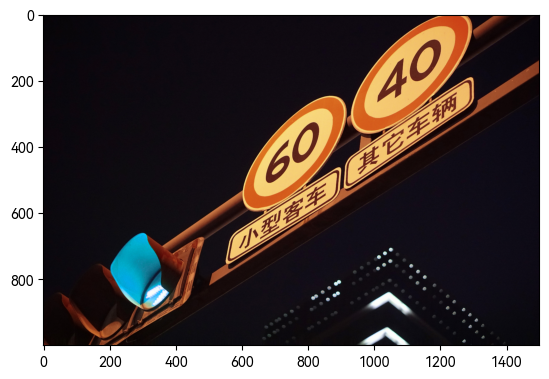

In [7]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("../img.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f"original image shape: {img.shape}")
img = cv2.resize(img, dsize=(img.shape[1] // 4, img.shape[0] // 4))
print(f"resized image shape: {img.shape}")
plt.subplot(111)
plt.imshow(img)
plt.savefig("./images/img.png")
plt.show()


In [8]:
import numpy as np
from matplotlib import font_manager

font_manager.fontManager.addfont("../fonts/HarmonyOS_Sans_SC_Regular.ttf")
plt.rcParams["font.sans-serif"] = ["HarmonyOS Sans SC"]
plt.rcParams["axes.unicode_minus"] = False


def subplot(position: int, img: np.ndarray, title=None):
    plt.subplot(position)
    plt.title(title) if title != None else plt.title(f"{img.shape[0]}*{img.shape[1]}")
    plt.imshow(img)


## 二、构建高斯金字塔

-   高斯金字塔主要用来向下降采样图像

    要从金字塔第 i 层生成 i+1 层，需要先用高斯核对图像 $G_i$ 进行卷积，然后删除所有偶数行和偶数列，新得到的图像就是 $G_{i+1}$，面积是源图像的 1/4。根据这样的规则对图像进行卷积和采样，就可以得到一个高斯金字塔。

-   opencv 中的从金字塔中上一级图像生成下一级图像可以用函数 `cv2.pyrDown()` 实现，也可以用函数 `cv2.pyrUp()` 实现从下一级图像生成上一级图像。
-   可以看出来向下采样会丢失图像信息


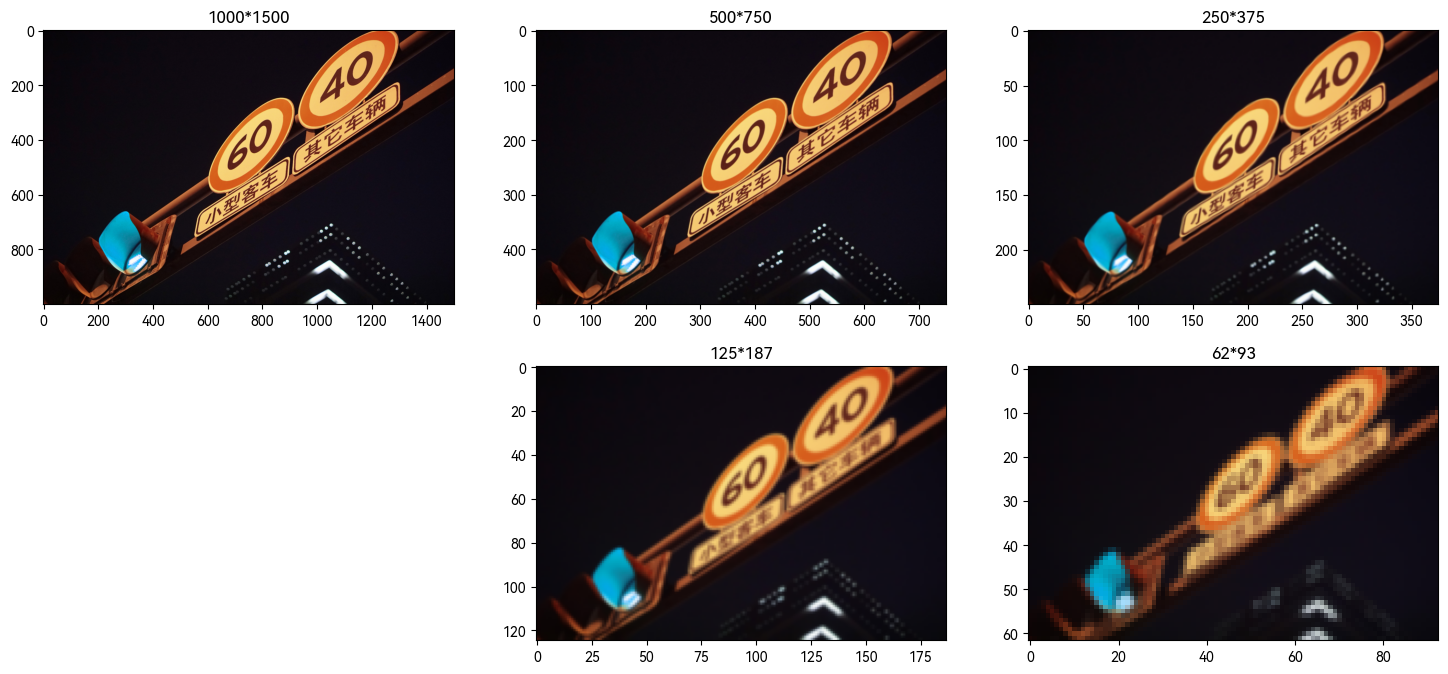

In [9]:
img1 = cv2.pyrDown(img, dstsize=(img.shape[1] // 2, img.shape[0] // 2))
img2 = cv2.pyrDown(img1, dstsize=(img1.shape[1] // 2, img1.shape[0] // 2))
img3 = cv2.pyrDown(img2, dstsize=(img2.shape[1] // 2, img2.shape[0] // 2))
img4 = cv2.pyrDown(img3, dstsize=(img3.shape[1] // 2, img3.shape[0] // 2))

plt.figure(figsize=(2 ^ 16, 2 ^ 10))
subplot(231, img, None)
subplot(232, img1, None)
subplot(233, img2, None)
subplot(235, img3, None)
subplot(236, img4, None)

plt.savefig("./images/gaussian_pyramid_down.png")
plt.show()


## 三、分别添加高斯噪声和椒盐噪声，并分别进行高斯平滑和中值滤波

处理后的图片放在一起更容易看出区别，故将添加噪声和滤波合并

### 3.1 高斯噪声

-   函数`gaussian_noise()`用于添加高斯噪声，参数为原图像和噪声的标准差

    由于标准差太小，噪声很难看出来，故两次实验的标准差分别为 60 和 100

-   在制作噪声时，像素的值可能大于 255 或者小于 0，故函数`clamp`用于限制像素值在 0-255 之间
-   分别对两张图进行高斯平滑和中值滤波
-   可以看出在中值滤波的效果要稍好与高斯平滑

    由于两次实验的标准差都比较大，当高斯噪声的标准差较小时，实际上原图和高斯平滑后图的 rmse 与原图和中值滤波后图的 rmse 差不多


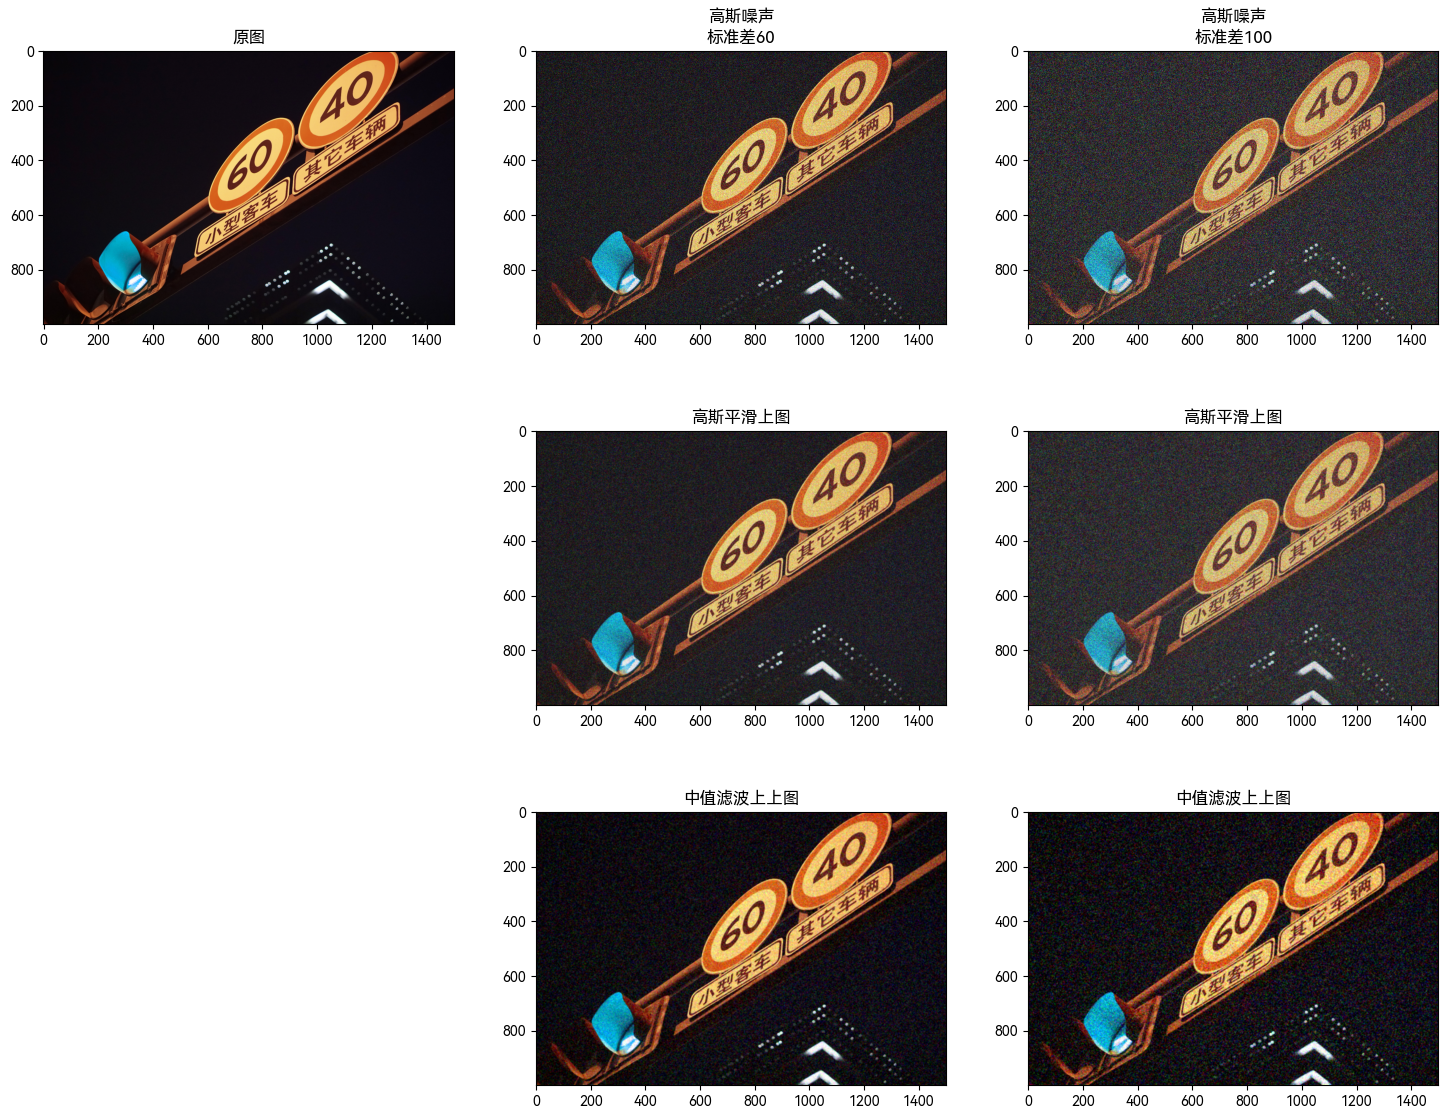

In [10]:
def clamp(pv):
    return 255 if pv > 255 else (0 if pv < 0 else pv)


def gaussian_noise(src, standard_deviation):
    image = src.copy()
    h, w, _ = image.shape
    for row in range(h):
        for col in range(w):
            s = np.random.normal(0, standard_deviation, 3)
            r = image[row, col, 0]
            g = image[row, col, 1]
            b = image[row, col, 2]
            image[row, col, 0] = clamp(r + s[0])
            image[row, col, 1] = clamp(g + s[1])
            image[row, col, 2] = clamp(b + s[2])
    return image


img_gaussian_60 = gaussian_noise(img, 60)
img_gaussian_100 = gaussian_noise(img, 100)
img_gaussian_60_gaussian = cv2.GaussianBlur(img_gaussian_60, (5, 5), 0)
img_gaussian_100_gaussian = cv2.GaussianBlur(img_gaussian_100, (5, 5), 0)
img_gaussian_60_median = cv2.medianBlur(img_gaussian_60, 5)
img_gaussian_100_median = cv2.medianBlur(img_gaussian_100, 5)


plt.figure(figsize=(2 ^ 16, 2 ^ 12))
subplot(331, img, "原图")
subplot(332, img_gaussian_60, "高斯噪声\n标准差60")
subplot(333, img_gaussian_100, "高斯噪声\n标准差100")
subplot(335, img_gaussian_60_gaussian, "高斯平滑上图")
subplot(336, img_gaussian_100_gaussian, "高斯平滑上图")
subplot(338, img_gaussian_60_median, "中值滤波上上图")
subplot(339, img_gaussian_100_median, "中值滤波上上图")
plt.savefig("./images/gaussian_noise.png")
plt.show()


### 3.2 椒盐噪声

-   函数`salt_pepper_noise()`用于添加椒盐噪声，参数为原图像和噪声的比例，实验中使用 20%的噪声比例和 50%的噪声比例
-   分别对两张图进行高斯平滑和中值滤波
-   中值滤波的效果远好于高斯平滑，但细节也有所遗失，不过它可以让整张图看上去更为正常


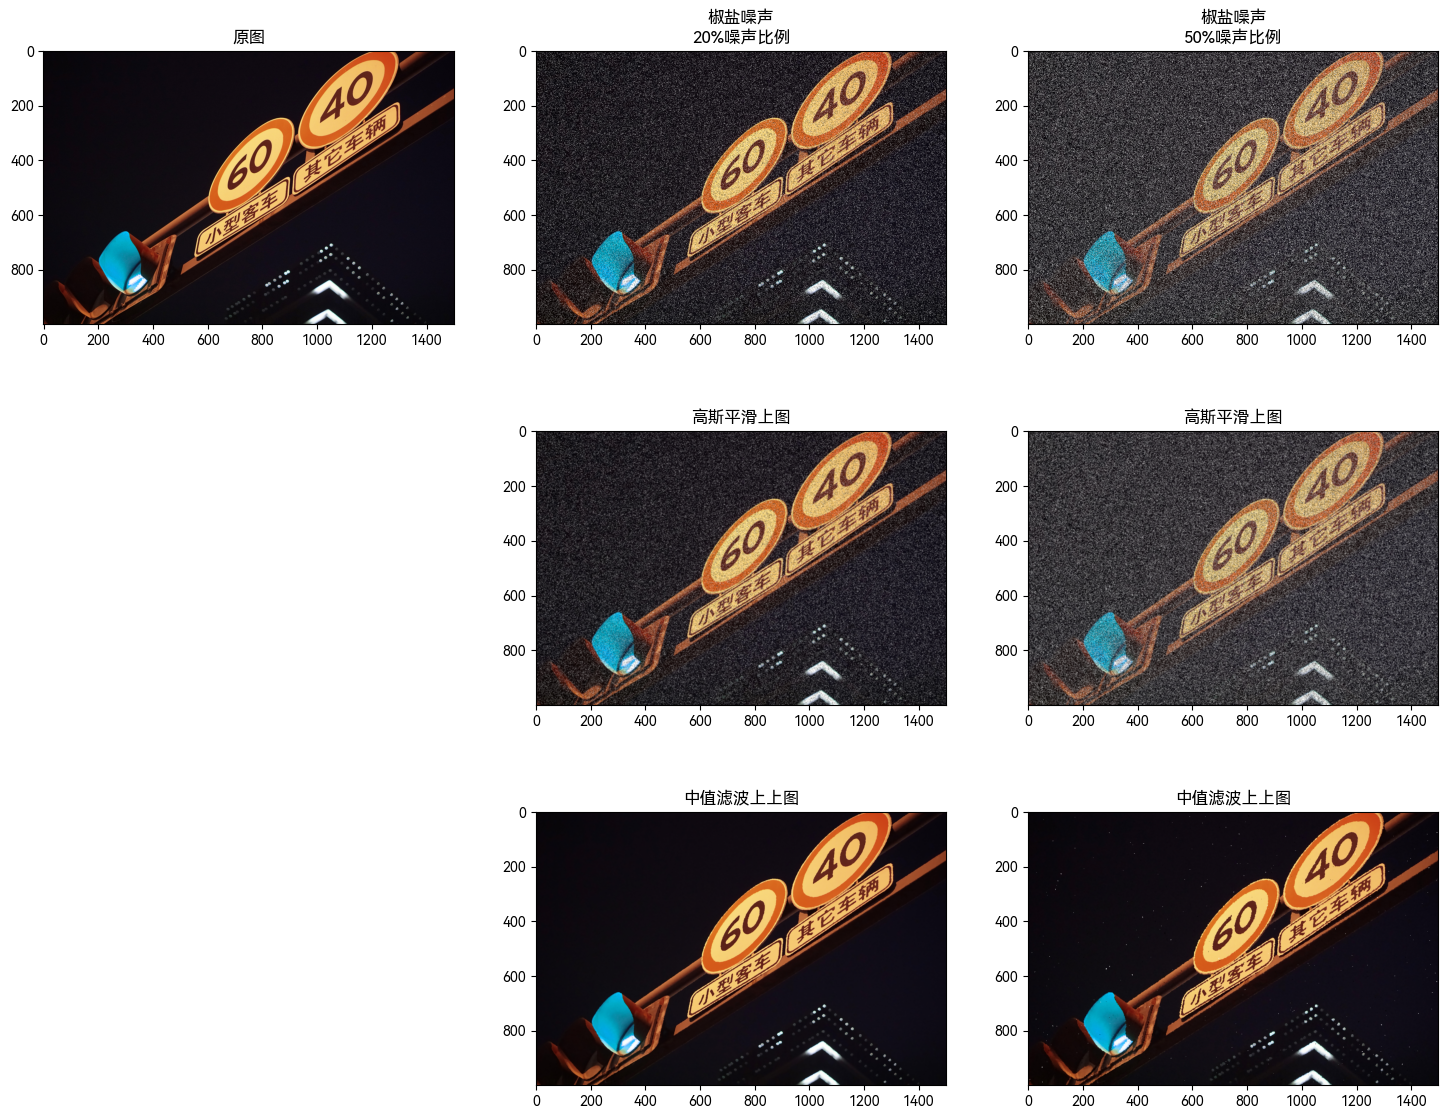

In [11]:
def salt_pepper_noise(src, snr):
    h = src.shape[0]
    w = src.shape[1]
    image = src.copy()
    sp = h * w
    num = int(sp * snr)
    for _ in range(num):
        randx = np.random.randint(1, h - 1)
        randy = np.random.randint(1, w - 1)
        image[randx, randy] = 0 if np.random.random() <= 0.5 else 255
    return image


img_salt_pepper_02 = salt_pepper_noise(img, 0.2)
img_salt_pepper_05 = salt_pepper_noise(img, 0.5)
img_salt_pepper_02_gaussian = cv2.GaussianBlur(img_salt_pepper_02, (5, 5), 0)
img_salt_pepper_05_gaussian = cv2.GaussianBlur(img_salt_pepper_05, (5, 5), 0)
img_salt_pepper_02_median = cv2.medianBlur(img_salt_pepper_02, 5)
img_salt_pepper_05_median = cv2.medianBlur(img_salt_pepper_05, 5)


plt.figure(figsize=(2 ^ 16, 2 ^ 12))
subplot(331, img, "原图")
subplot(332, img_salt_pepper_02, "椒盐噪声\n20%噪声比例")
subplot(333, img_salt_pepper_05, "椒盐噪声\n50%噪声比例")
subplot(335, img_salt_pepper_02_gaussian, "高斯平滑上图")
subplot(336, img_salt_pepper_05_gaussian, "高斯平滑上图")
subplot(338, img_salt_pepper_02_median, "中值滤波上上图")
subplot(339, img_salt_pepper_05_median, "中值滤波上上图")
plt.savefig("./images/salt_pepper_noise.png")
plt.show()


## 四、计算添加噪声和滤波后的图像与原图的 rmse


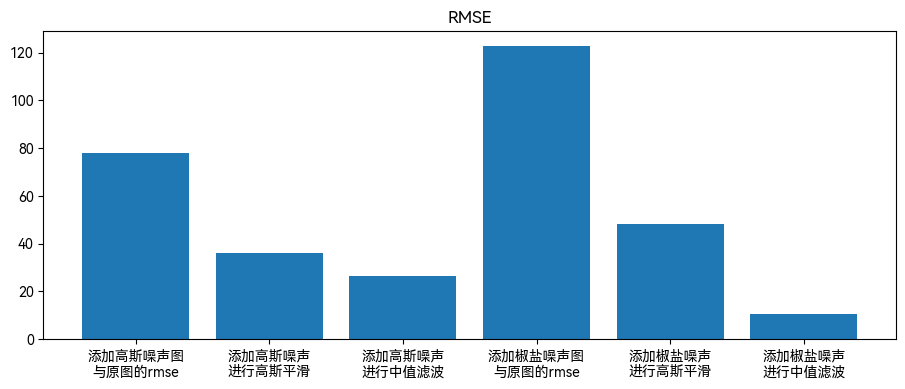

In [12]:
def rmse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return np.sqrt(err)


gaussian_noise_rmse = rmse(img, img_gaussian_60)
gaussian_blur_gaussian_noise = rmse(img, img_gaussian_60_gaussian)
median_blur_gaussian_noise = rmse(img, img_gaussian_60_median)
salt_pepper_noise_rmse = rmse(img, img_salt_pepper_02)
gaussian_blur_salt_pepper_noise = rmse(img, img_salt_pepper_02_gaussian)
median_blur_salt_pepper_noise = rmse(img, img_salt_pepper_02_median)

x = np.array(["添加高斯噪声图\n与原图的rmse", "添加高斯噪声\n进行高斯平滑", "添加高斯噪声\n进行中值滤波",
              "添加椒盐噪声图\n与原图的rmse", "添加椒盐噪声\n进行高斯平滑", "添加椒盐噪声\n进行中值滤波"])
y = np.array([gaussian_noise_rmse, gaussian_blur_gaussian_noise, median_blur_gaussian_noise,
              salt_pepper_noise_rmse, gaussian_blur_salt_pepper_noise, median_blur_salt_pepper_noise])


plt.figure(figsize=(2 ^ 9, 2 ^ 6))
plt.title("RMSE")
plt.bar(x, y)
plt.savefig("./images/rmse.png")
plt.show()
